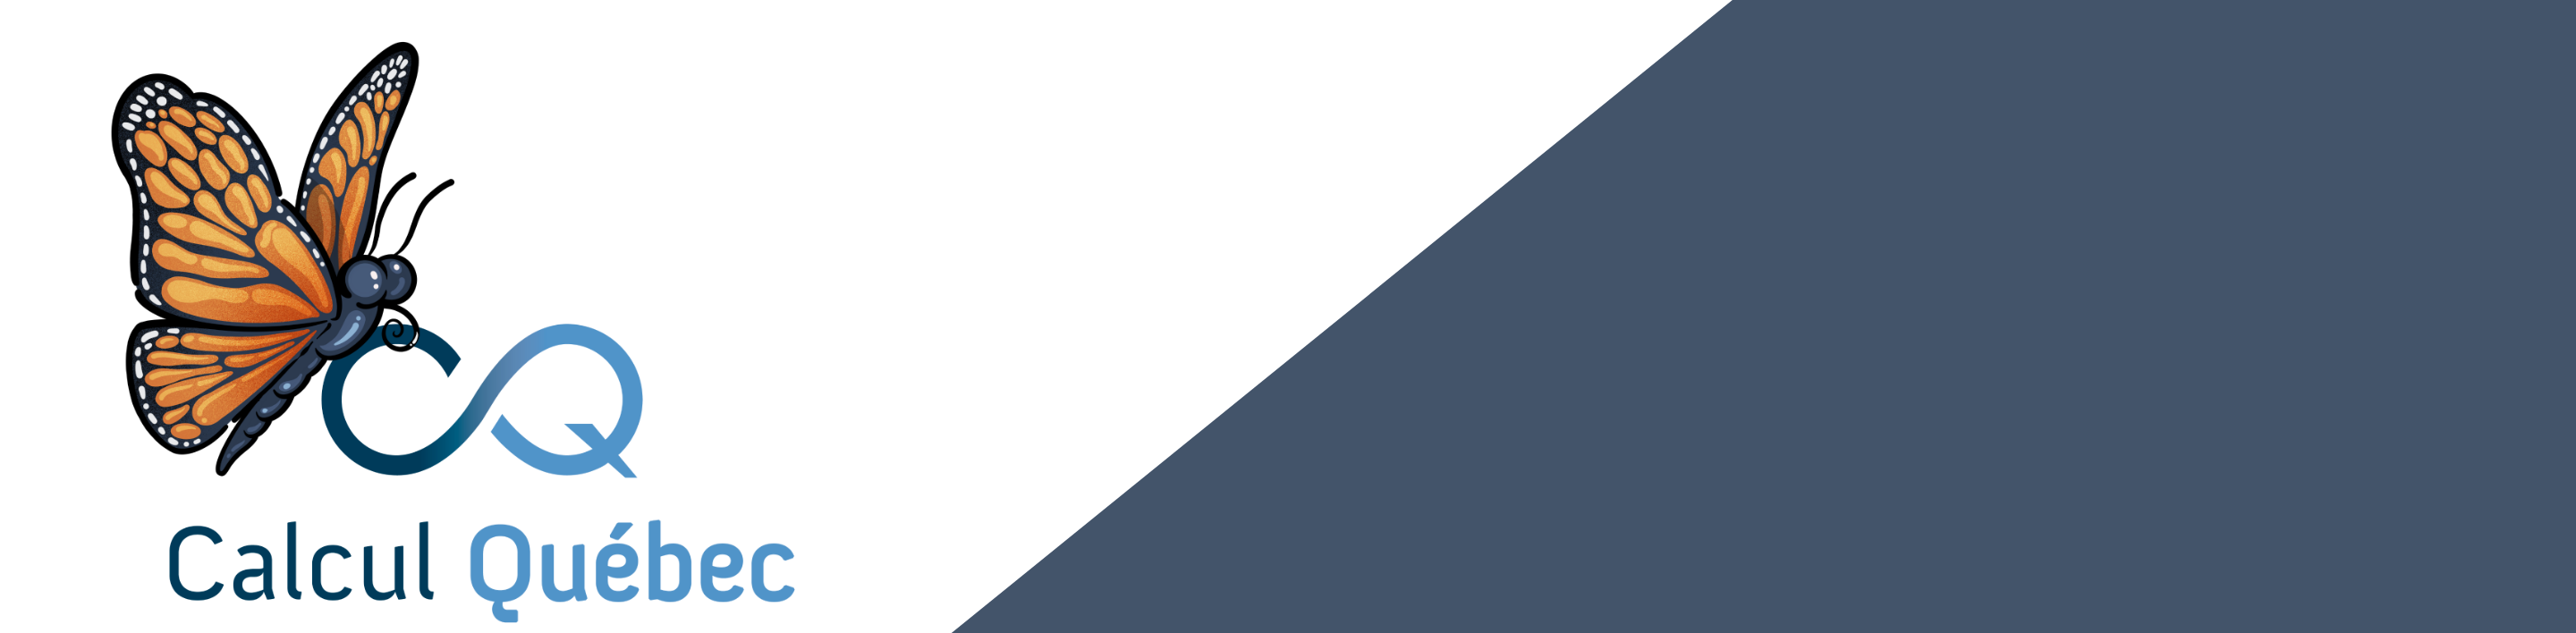

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

## Algorithme hybride

Dans le notebook 3, nous avons passé beaucoup de temps à concevoir manuellement des circuits pour préparer certains états quantiques. Une autre approche, très utilisée aujourd’hui, consiste à laisser un **algorithme hybride quantique-classique** ajuster automatiquement le circuit afin de minimiser une fonction objectif.


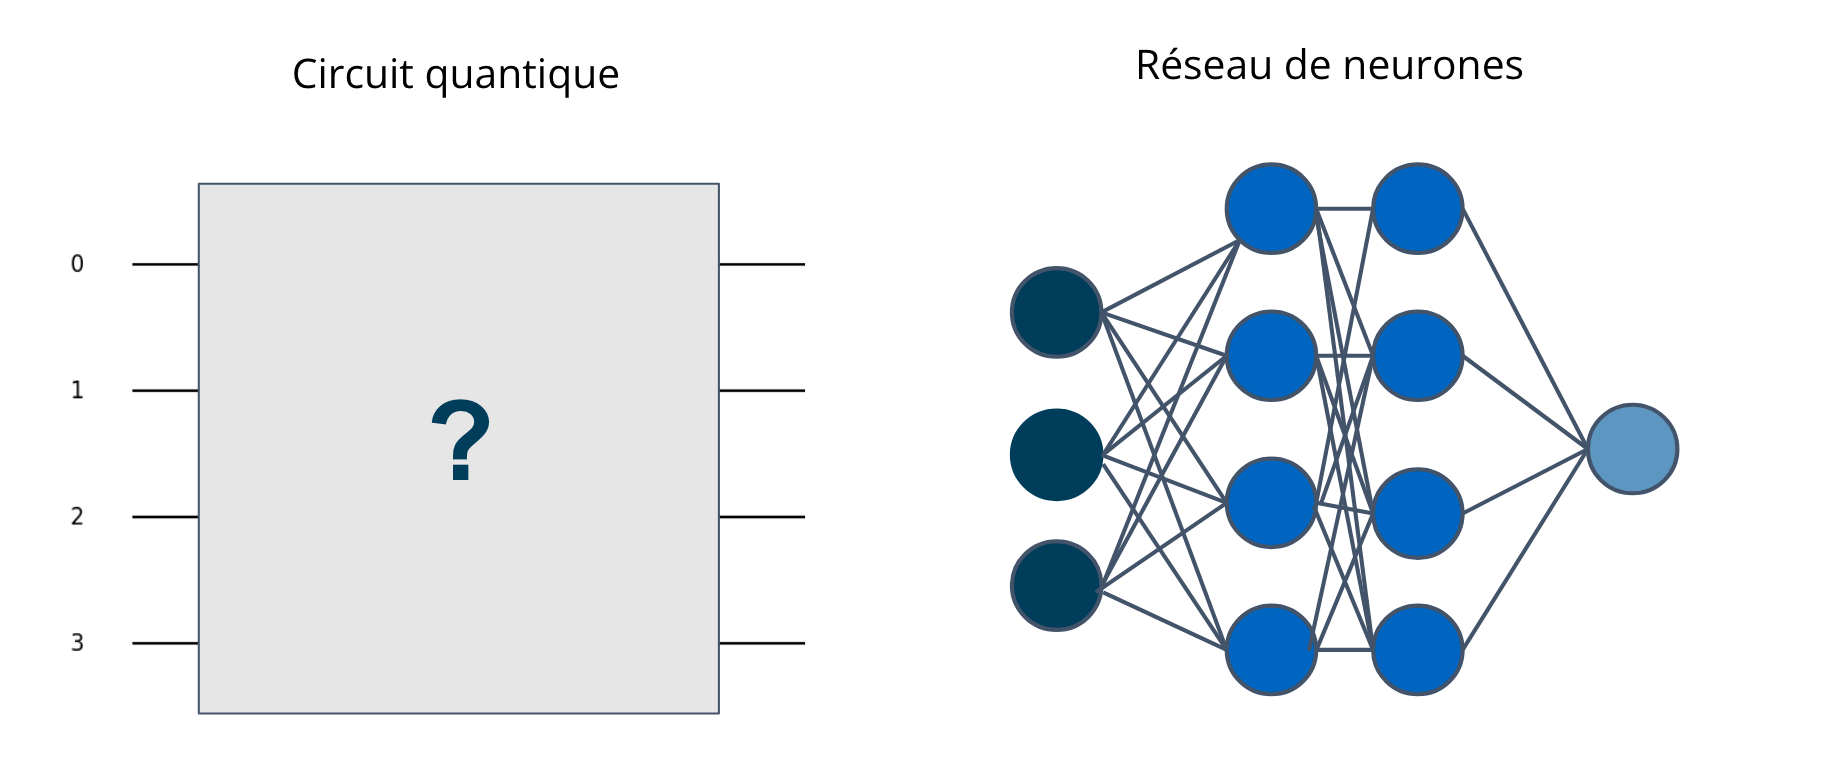


Ces **algorithmes variationnels** utilisent un circuit paramétré exécuté sur l’ordinateur quantique, et un optimiseur classique qui met à jour les paramètres. On peut imaginer un réseau de neurones où les paramètres à optimiser correspondent aux angles de rotation sur la sphère de Bloch.


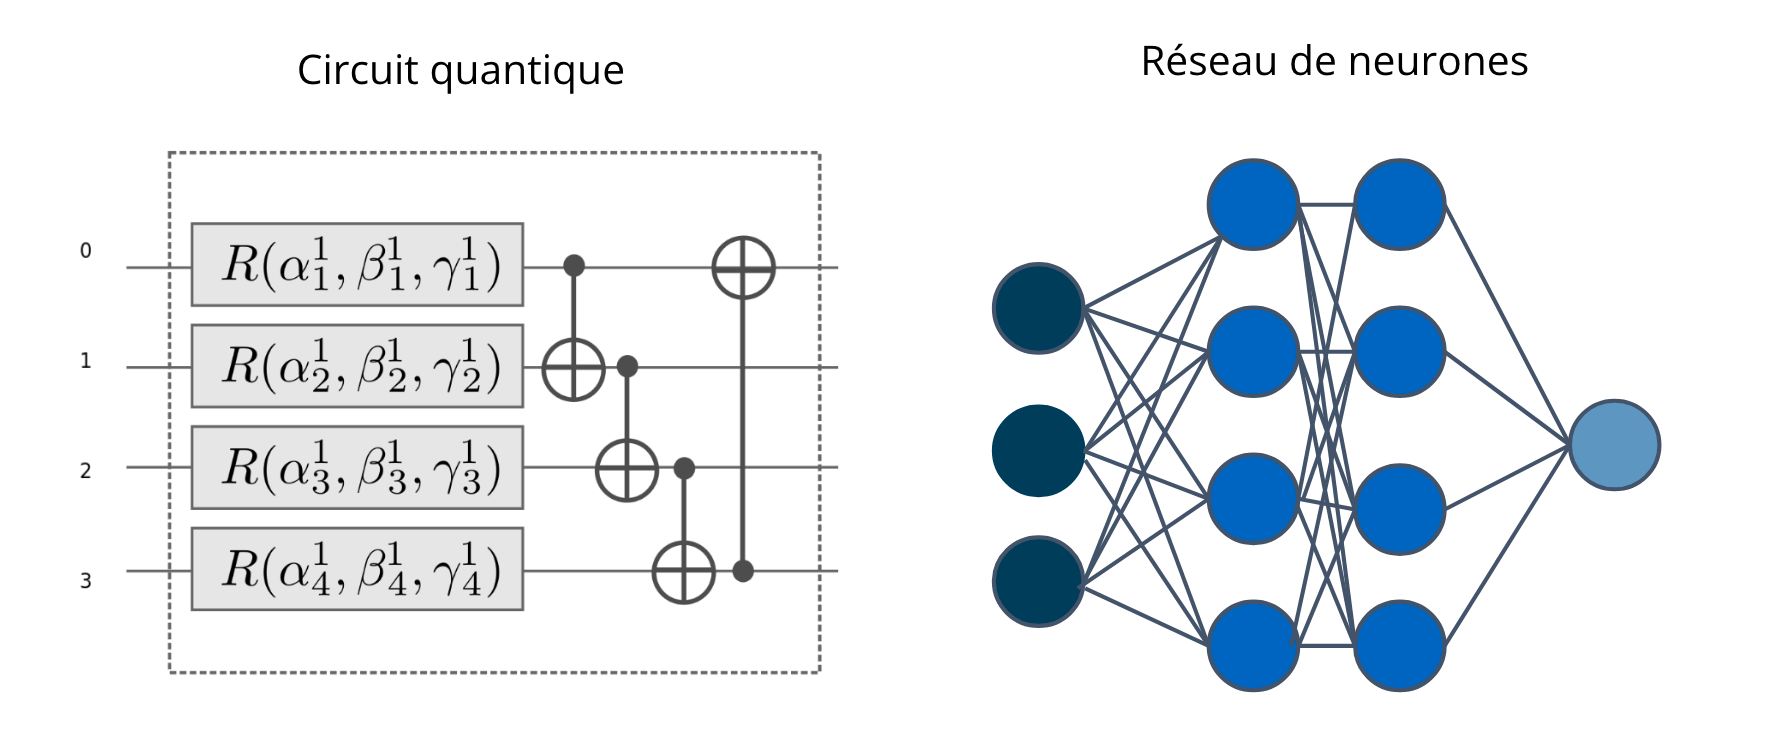

EXERCICE 6


---

Un exemple simple d'un circuit paramétré consiste à appliquer des **rotations** autour des axes $x$ et $y$ de la sphère de Bloch. Les angles de ces rotations sont nos paramètres variationnels. En modifiant ces angles, on peut explorer différents états quantiques.

Dans cet exercice, vous allez compléter la fonction `variational_circuit` qui applique une rotation $R_x(\theta_x)$ suivie d’une rotation $R_y(\theta_y)$ sur un qubit initialement dans l’état $\lvert 0 \rangle$. Les angles sont donnés dans le array `params`.

In [ ]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def variational_circuit(observable, params):
    """
    Implémente un circuit variationnel simple avec deux rotations :
    Rx et Ry, dont les angles sont donnés dans params.

    Args:
        observable (qml.operation.Observable): L'observable à mesurer.
        params (list[float]): Liste de deux paramètres (theta_x, theta_y).

    Returns:
        float: La valeur moyenne <observable>.
    """
    # Complétez cette ligne 
    # Complétez cette ligne 
    
    return qml.expval(observable)

# Exemple de test avec l'observable PauliZ
params = np.array([0.1, 0.2], requires_grad=True)
print("Résultat =", variational_circuit(qml.PauliZ(0), params))

La partie "quantique" de l'algorithme est complétée: le circuit paramétré prépare un état et permet de mesurer une observable. La prochaine étape consiste à définir une **fonction coût** qui quantifie à quel point le résultat du circuit s’éloigne de l’objectif souhaité, puis à utiliser un **algorithme d’optimisation classique** pour trouver les paramètres qui minimisent cette fonction coût. Un exemple simple est la **descente de gradient**, mais d’autres méthodes plus sophistiquées existent. [Vous pouvez consulter cette liste](https://docs.pennylane.ai/en/stable/introduction/interfaces.html) . 

In [ ]:
init_params = np.array([0.5, 0.1], requires_grad = True) #Définir les paramètres initiaux

#Fonction de coût à minimiser
def cost_function(params):
    return variational_circuit(qml.PauliZ(0), params)

#Optimiseur 
opt = qml.GradientDescentOptimizer(stepsize = 0.4)

params = init_params

cost_arr = []
steps = 20
for i in range(steps):
    params, cost = opt.step_and_cost(cost_function, params)
    print(f"Step {i}: cost = {cost_function(params)}")

    cost_arr.append(cost)

print("\nLes angles qui minimisent la fonction de coût sont", params)

On voit bien que la la fonction de cout est minimisée avec l'algorithme de descente par gradient.

In [ ]:
plt.plot(range(steps), cost_arr)
plt.xlabel("Iterations")
plt.ylabel("Cost")

## Exemple : molécule H₂ 

Pour voir un problème utile, considérons la molécule d’hydrogène H₂.

En chimie et en physique, on cherche souvent **l’énergie de l’état fondamental (ground state)** d’un système. Cette énergie minimale correspond à la configuration la plus stable de la molécule. À partir de là, nous pouvons prédire la réactivité chimique, la force des liaisons et la stabilité des matériaux.

Pourquoi s'intéresser à l'état fondamental d'une molécule?

**Découverte de médicaments** -> prédire comment une molécule se lie à une protéine.

**Conception de catalyseurs** -> trouver des réactions efficaces pour l'industrie ou l'énergie propre (par exemple, synthèse d'ammoniac, production d'hydrogène).

**Matériaux pour batteries** -> étudier les composés de lithium ou les métaux de transition afin d'améliorer le stockage d'énergie.



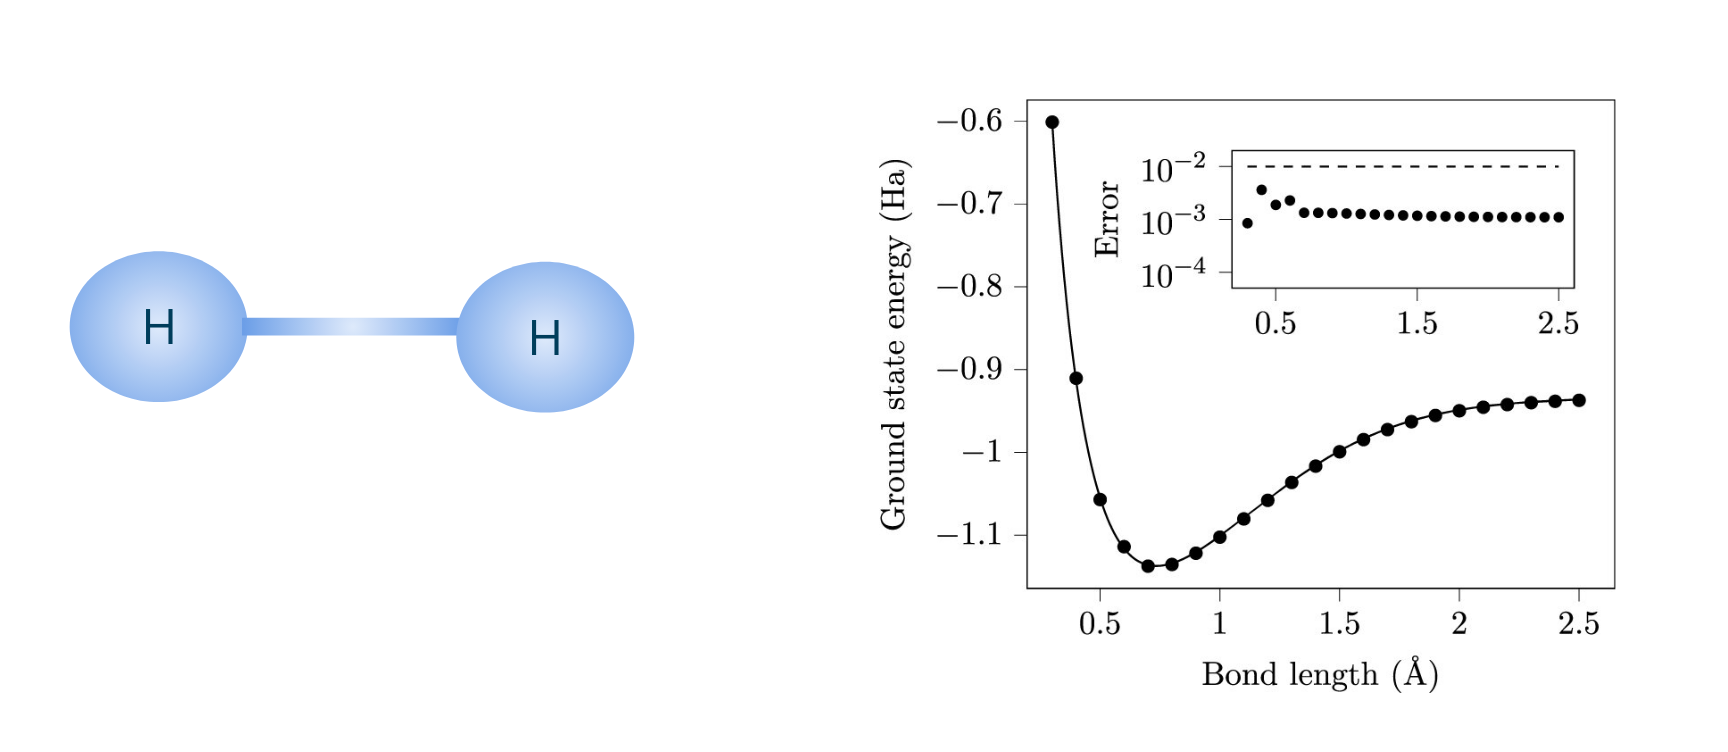



Avec un **algorithme variationnel**, nous allons construire un circuit quantique **paramétré** dont les paramètres sont ajustés pour **minimiser l’énergie** du système. L’idée est la même que pour notre exemple précédent :

1. On prépare un état quantique initial (par exemple l’état Hartree-Fock).
2. On applique un circuit paramétré (ansatz) qui dépend de paramètres ajustables.
3. On mesure l’**observable énergie** correspondante à la molécule.
4. Un **optimiseur classique** ajuste les paramètres pour réduire l’énergie mesurée.

Ainsi, le calcul quantique se concentre sur la préparation et la mesure d’états, tandis que l’optimisation est faite classiquement. C’est le principe des **algorithmes variationnels hybrides** (VQE).

In [ ]:
# Loader les données de la molécules H2 directement de PennyLane (pour cet exemple)
# PennyLane nous donne directement l'hamiltonien de H2 (la fonction qui détermine l'énergie)
dataset = qml.data.load("qchem", molname="H2")[0]
H, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)


#Formuler un ansatz plausible (utilise des connaissances de chimie)
#Cela permet de réduire le nombre de paramètres à optimiser
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print("Hartree–Fock state:", hf)

#Circuit qui retourne l'énergie du système
dev = qml.device("default.qubit", wires=qubits)
@qml.qnode(dev)
def circuit(param):
    qml.BasisState(hf, wires=range(qubits)) #vient préparer l'état dans un état Hartree-Fock
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3]) #une rotation spéciale paramétrée par `param`
    return qml.expval(H)

# Fonction de cout
def cost_fn(param):
    return circuit(param)

# Optimisation
opt = qml.GradientDescentOptimizer(stepsize=0.4)
params = np.array(0.0, requires_grad=True)  # initial parameter
n_steps = 50

energies = []
for i in range(n_steps):
    params, energy = opt.step_and_cost(cost_fn, params)
    energies.append(energy)
    if i % 10 == 0:
        print(f"Step {i}: Energy = {energy:.6f}")

print("\nÉnergie finale après optimisation:", energies[-1])
print("\nÉnergie fondamentale (exacte):", min(np.linalg.eigvals(qml.matrix(H))))
print("\nParamètre optimisé du circuit", params)